# Experiment 1: HANK with different borrowing constraints
How much agents can smooth their consumption after a shock occurs depends on how much they are allowed to borrow.

In this notebook, we differentiate between a HANK model with
- One household type which cannot borrow
- One household type which can borrow
- Two household types where one can borrow and one cannot

### Assume same discount factor

In [40]:
from ConsIndShockModel_HANK_Borrowing import IndShockConsumerType 
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

### Test: With Borrowing Constraint?!

In [41]:
r_ss = 1.03 - 1
Z_ss = 0.7925

In [42]:
HANK_Borrowing_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,                   # Allowing for borrowing (Will use natural borrowing constraint)
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Borrowing_Dict['TranShkMean_Func'] = [function]

In [43]:
Agent_GE_Borrowing = IndShockConsumerType(**HANK_Borrowing_Dict)

In [44]:
Agent_GE_Borrowing.solve()

In [45]:
### Steady State
HANK_Borrowing_Dict['mMin'] = Agent_GE_Borrowing.solution[0].mNrmMin
Agent_GE_Borrowing.mMin = HANK_Borrowing_Dict['mMin'] + 0.001

Agent_GE_Borrowing.define_distribution_grid()

dist_mGrid = Agent_GE_Borrowing.dist_mGrid



In [46]:
Agent_GE_Borrowing.calc_transition_matrix()

In [47]:
Agent_GE_Borrowing.tran_matrix

[array([[0.0491329 , 0.00171449, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.0005546 , 0.04737206, 0.00176084, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00060096, 0.04727659, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])]

In [48]:
from HARK.utilities import (
    construct_assets_grid,
    gen_tran_matrix_1D,
    gen_tran_matrix_2D,
    jump_to_grid_1D,
)

In [49]:
dist_mGrid = Agent_GE_Borrowing.dist_mGrid  # Grid of market resources
dist_pGrid = Agent_GE_Borrowing.dist_pGrid  # Grid of permanent incomes
# assets next period
aNext = dist_mGrid - Agent_GE_Borrowing.solution[0].cFunc(dist_mGrid)

Agent_GE_Borrowing.aPol_Grid = aNext  # Steady State Asset Policy Grid
# Steady State Consumption Policy Grid
Agent_GE_Borrowing.cPol_Grid = Agent_GE_Borrowing.solution[0].cFunc(dist_mGrid)

# Obtain shock values and shock probabilities from income distribution
# Bank Balances next period (Interest rate * assets)
bNext = Agent_GE_Borrowing.Rfree * aNext

In [50]:
### To calculate tranistion matrix
shk_dstn = Agent_GE_Borrowing.IncShkDstn     

shk_prbs = shk_dstn[0].pmv  # Probability of shocks
tran_shks = shk_dstn[0].atoms[1]  # Transitory shocks
perm_shks = shk_dstn[0].atoms[0]  # Permanent shocks
LivPrb = Agent_GE_Borrowing.LivPrb[0]  # Update probability of staying alive


NewBornDist = jump_to_grid_1D(
    np.zeros_like(tran_shks),
    shk_prbs,
    dist_mGrid,)


# Compute Transition Matrix given shocks and grids.
tran_matrix = gen_tran_matrix_1D(
    dist_mGrid,
    bNext,
    shk_prbs,
    perm_shks,
    tran_shks,
    LivPrb,
    NewBornDist,
)

In [51]:
NewBornDist

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [52]:
dist_mGrid[0]

0.00199999999999989

In [53]:
np.mean(NewBornDist)

0.005000000000000002

In [54]:
np.mean(tran_matrix)

0.004999999999999999

In [55]:
# Agent_GE_Borrowing.vec_erg_dstn

In [56]:
Agent_GE_Borrowing.T_sim = 1000
Agent_GE_Borrowing.AgentCount = 10000
Agent_GE_Borrowing.track_vars = ['mNrm', 'cNrm', 'aNrm', 'pLvl', 'aLvl']

In [57]:
Agent_GE_Borrowing.initialize_sim()

In [58]:
Agent_GE_Borrowing.simulate()

{'mNrm': array([[1.37574077, 2.10541542, 1.46702615, ..., 1.69060126, 1.16511383,
         2.8109848 ],
        [1.25893363, 1.67520429, 1.15312474, ..., 1.26651779, 1.18327565,
         1.82628537],
        [1.09767445, 1.25948255, 1.3559932 , ..., 1.08250325, 1.38134527,
         1.50375513],
        ...,
        [0.84687346, 0.25082479, 1.33458101, ..., 0.86581012, 1.08029907,
         1.39447457],
        [1.10583605, 0.04272293, 0.35161905, ..., 0.94813876, 0.87868012,
         1.20540239],
        [1.1769476 , 0.62904471, 0.89039225, ..., 1.03947684, 1.10316075,
         1.07530614]]),
 'cNrm': array([[1.00411516, 1.41648041, 1.05831871, ..., 1.18721586, 0.87406425,
         1.7920382 ],
        [0.93294197, 1.17848916, 0.86644113, ..., 0.93760072, 0.88561222,
         1.26332394],
        [0.83075996, 0.93327916, 0.99217595, ..., 0.82093406, 1.007481  ,
         1.07989417],
        ...,
        [0.66118803, 0.20532471, 0.97923032, ..., 0.67444802, 0.81950649,
         1.0153014

In [59]:
np.mean(Agent_GE_Borrowing.state_now["aLvl"])

36.77313490274725

In [60]:
Agent_GE_Borrowing.compute_steady_state()

GPFRaw                 = 0.984539 
GPFNrm                 = 0.987723 
GPFAggLivPrb           = 0.978385 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 1.006745 
uInvEpShkuInv          = 0.996777 
VAF                    = 0.950925 
WRPF                   = 0.215199 
DiscFacGPFNrmMax       = 0.984014 
DiscFacGPFAggLivPrbMax = 0.996617 


(1.027088634991903, 0.8117671641222298)

### Test: No Borrowing Constraint end

In [61]:
stop

NameError: name 'stop' is not defined

In [ ]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [ ]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss = Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [ ]:
HANK_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,                   # Allowing for borrowing (Will use natural borrowing constraint)
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

In [ ]:
# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict['TranShkMean_Func'] = [function]

In [ ]:
### Target Steady State Asset
def ss_func(beta):
    HANK_Dict['DiscFac'] = beta
    Agent_func = IndShockConsumerType(**HANK_Dict, verbose = False)
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [ ]:
np.max([-1.0, 0.0])

0.0

In [ ]:
# Create a new agent
HANK_Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**HANK_Dict, verbose = False)

In [ ]:
A_ss, C_ss = Agent_GE.compute_steady_state()
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.97. Where the steady state MPC is 0.27 and Bond Holdings are 0.25


In [ ]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 20.966347217559814


### Allow for borrowing

In [ ]:
HANK_Borrowing_Dict = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Z_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": -10.0,                   # Allowing for borrowing (Will use natural borrowing constraint)
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

HANK_Borrowing_Dict['TranShkMean_Func'] = [function]

In [ ]:
# ### Target Steady State Asset
# def ss_func(beta):
#     HANK_Borrowing_Dict['DiscFac'] = beta
#     Agent_func = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)
#     Agent_func.solve()
#     HANK_Borrowing_Dict['mMin'] = Agent_func.solution[0].mNrmMin
#     Agent_func = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)
#     A_ss = Agent_func.compute_steady_state()[0]
#     return A_ss
    

# def ss_dif(beta):    
#     return ss_func(beta) - Asset_target 

# Asset_target = B_ss
# DiscFac = optimize.brentq(ss_dif,.75,.99)

In [ ]:
# Create a new agent
HANK_Borrowing_Dict['DiscFac'] = HANK_Dict['DiscFac']
Agent_GE_Borrowing = IndShockConsumerType(**HANK_Borrowing_Dict, verbose = False)

In [ ]:
Agent_GE_Borrowing.solve()

In [ ]:
Agent_GE_Borrowing.solution[0].mNrmMin


-0.5308224130116708

In [ ]:
HANK_Borrowing_Dict['mMin'] = Agent_GE_Borrowing.solution[0].mNrmMin
Agent_GE_Borrowing.mMin = HANK_Borrowing_Dict['mMin'] + 0.001

Agent_GE_Borrowing.define_distribution_grid()

dist_mGrid = Agent_GE_Borrowing.dist_mGrid

Agent_GE_Borrowing.compute_steady_state()

In [ ]:
Agent_GE_Borrowing.define_distribution_grid()

In [ ]:
dist_mGrid = Agent_GE_Borrowing.dist_mGrid

In [ ]:
dist_mGrid[0]

-0.5298224130116708

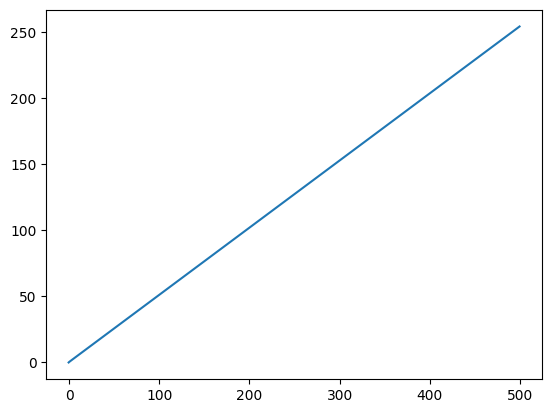

In [ ]:
plt.plot(dist_mGrid, Agent_GE_Borrowing.solution[0].cFunc(dist_mGrid))

In [ ]:
Agent_GE_Borrowing.solution[0].cFunc(dist_mGrid)

array([8.38035921e-04, 5.46377284e-03, 1.00838898e-02, 1.47814597e-02,
       1.95582235e-02, 2.44159713e-02, 2.93565440e-02, 3.43818351e-02,
       3.94937925e-02, 4.46944204e-02, 4.99857808e-02, 5.53699963e-02,
       6.06295590e-02, 6.58773936e-02, 7.12189621e-02, 7.66565090e-02,
       8.21923463e-02, 8.78288558e-02, 9.35684917e-02, 9.92546944e-02,
       1.04840768e-01, 1.10530942e-01, 1.16327818e-01, 1.22234076e-01,
       1.28252482e-01, 1.34089684e-01, 1.40017681e-01, 1.46060402e-01,
       1.52220823e-01, 1.58402977e-01, 1.64541714e-01, 1.70802374e-01,
       1.77188198e-01, 1.83614295e-01, 1.90037635e-01, 1.96591981e-01,
       2.03280906e-01, 2.09954708e-01, 2.16732728e-01, 2.23652794e-01,
       2.30635341e-01, 2.37687034e-01, 2.44889615e-01, 2.52186178e-01,
       2.59559221e-01, 2.67093405e-01, 2.74727982e-01, 2.82469804e-01,
       2.90384517e-01, 2.98392325e-01, 3.06551674e-01, 3.14888590e-01,
       3.23321423e-01, 3.31949643e-01, 3.40729127e-01, 3.49669393e-01,
      

In [ ]:
Agent_GE_Borrowing.compute_steady_state()

(-1.8753115247339749, 0.883525390680572)

In [ ]:
Agent_GE_Borrowing.DiscFac

0.965554524540225

In [ ]:
Agent_GE.compute_steady_state()
Agent_GE.DiscFac

0.965554524540225

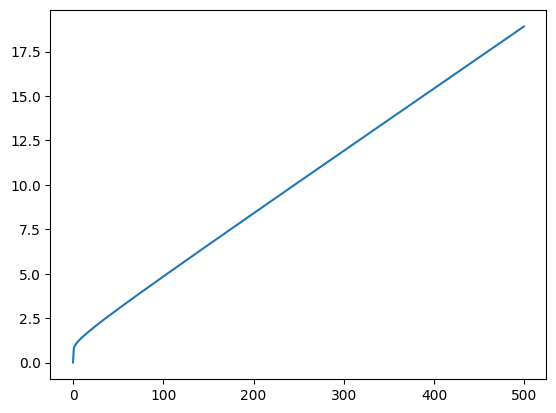

In [ ]:
plt.plot(dist_mGrid, Agent_GE.solution[0].cFunc(dist_mGrid))

In [ ]:
Agent_GE.solution[0].cFunc(dist_mGrid)

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

In [ ]:
Agent_GE_Borrowing.calc_transition_matrix()


In [ ]:
np.max(Agent_GE_Borrowing.tran_matrix)

0.7883240772564832

In [ ]:
Agent_GE.tran_matrix

array([[0.00625   , 0.00625   , 0.00625   , ..., 0.00625   , 0.00625   ,
        0.00625   ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.5715376 , 0.2531125 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16297033, 0.58070286,
        0.24718082],
       [0.        , 0.        , 0.        , ..., 0.        , 0.15993464,
        0.74656918]])

In [ ]:
## 'cheating' using SS values from the model without borrowing
A_ss, C_ss = Agent_GE.compute_steady_state()

In [ ]:
Agent_GE_Borrowing.A_ss = A_ss
Agent_GE_Borrowing.C_ss = C_ss

In [ ]:
Agent_GE_Borrowing.calc_jacobian('labor',T)

(array([[ 1.58478114e+03, -8.79274800e+03, -5.61857699e+03, ...,
         -1.01603699e+02, -1.01603699e+02, -1.01603699e+02],
        [ 1.46480383e+03,  4.74064177e+02, -8.52516893e+03, ...,
         -1.01940884e+02, -1.01940884e+02, -1.01940884e+02],
        [ 1.39025153e+03,  3.38211766e+02,  6.21680850e+02, ...,
         -1.03322107e+02, -1.03322107e+02, -1.03322107e+02],
        ...,
        [ 1.31711396e+03, -9.09494702e-13, -4.09272616e-12, ...,
          6.76468422e+02, -8.40198757e+03, -5.35050693e+03],
        [ 1.31711396e+03, -9.09494702e-13, -4.09272616e-12, ...,
          4.35466837e+02,  6.76468422e+02, -8.40198757e+03],
        [ 1.31711396e+03, -9.09494702e-13, -4.09272616e-12, ...,
          2.58689787e+02,  4.35466837e+02,  6.76468422e+02]]),
 array([[-1.77551287e+04,  1.40809721e+04,  1.09068011e+04, ...,
          5.38982783e+03,  5.38982783e+03,  5.38982783e+03],
        [-1.94612236e+04,  6.82681425e+03,  1.78643153e+04, ...,
          5.38287252e+03,  5.38287252e

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
A_ss, C_ss = Agent_GE_Borrowing.compute_steady_state()
MPC = Agent_GE_Borrowing.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE_Borrowing.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

Our general equilibrium agent has a discount rate of: 0.97. Where the steady state MPC is 267.67 and Bond Holdings are -1.94


In [ ]:
start = time.time()

CJACR_Borrowing, AJACR_Borrowing = Agent_GE_Borrowing.calc_jacobian('Rfree',T)
CJACZ_Borrowing, AJACZ_Borrowing = Agent_GE_Borrowing.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.51484203338623


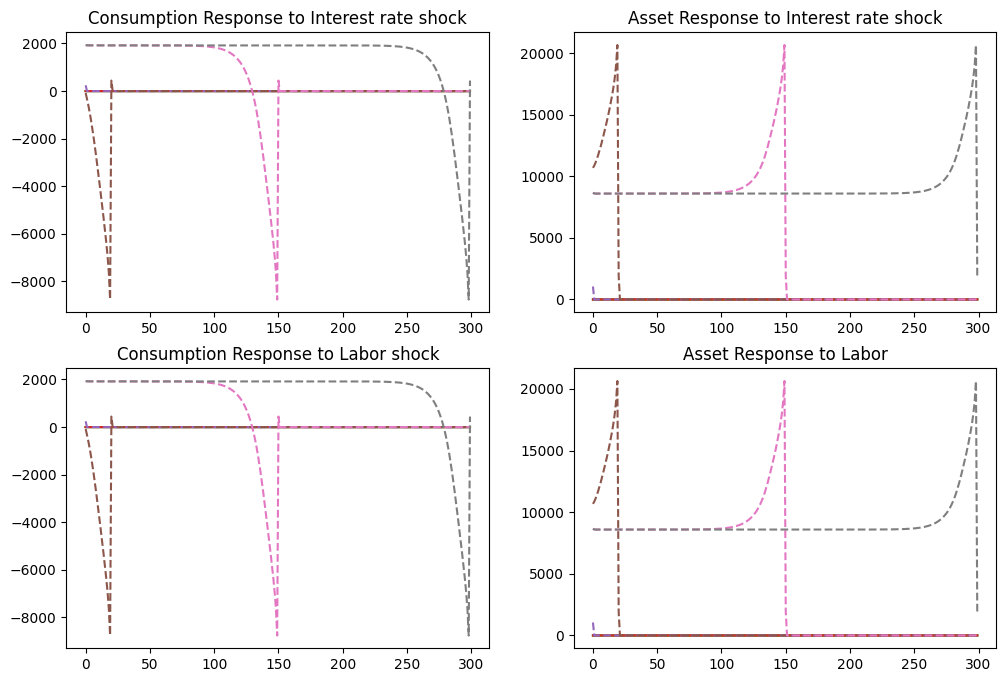

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].plot(CJACR_Borrowing.T[0], '--')
axs[0, 0].plot(CJACR_Borrowing.T[20], '--')
axs[0, 0].plot(CJACR_Borrowing.T[150], '--')
axs[0, 0].plot(CJACR_Borrowing.T[-1], '--')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].plot(AJACR_Borrowing.T[0], '--')
axs[0, 1].plot(AJACR_Borrowing.T[20], '--')
axs[0, 1].plot(AJACR_Borrowing.T[150], '--')
axs[0, 1].plot(AJACR_Borrowing.T[-1], '--')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].plot(CJACZ_Borrowing.T[0], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[20], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[150], '--')
axs[1, 0].plot(CJACZ_Borrowing.T[-1], '--')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].plot(AJACZ_Borrowing.T[0], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[20], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[150], '--')
axs[1, 1].plot(AJACZ_Borrowing.T[-1], '--')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()